In [1]:
import open3d as o3d
import open3d.t.io as o3dt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import laspy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [108]:
# Load and merge point clouds
data_folder = "../data/"
data_toronto = f"{data_folder}Toronto_3D/"
files = [f"{data_toronto}L001.ply", f"{data_toronto}L002.ply", 
         f"{data_toronto}L003.ply", f"{data_toronto}L004.ply"]

# Initialize lists to store features and labels from all files
all_features = []
all_labels = []

# Process each file
for file in files:
    # Load the point cloud
    cloud = o3dt.read_point_cloud(file)
    
    # Extract attributes
    positions = cloud.point["positions"].numpy()  # Shape: (N, 3)
    colors = cloud.point["colors"].numpy()  # Shape: (N, 3)
    labels = cloud.point["scalar_Label"].numpy()  # Shape: (N, 1)

    # Combine positions and colors as features
    features = np.hstack((positions, colors))  # Shape: (N, 6)
    
    # Append to the lists
    all_features.append(features)
    all_labels.append(labels)


# Concatenate all features and labels from multiple files
all_features = np.vstack(all_features)  # Final shape: (total_points, 6)
all_labels = np.vstack(all_labels).flatten()  # Final shape: (total_points,)

# Offset
positional_offset = all_features[:, :3].mean(axis=0)
all_features[:, :3] -= positional_offset

In [109]:
# Define the class mapping
class_mapping = {
    2: 1,  # Road_markings (2) -> Ground (1)
    8: 0   # Fence (8) -> Unclassified (0)
}

# Remap all_labels and decrease labels above 2 by 1
all_labels_remapped = np.array([class_mapping.get(label, label) for label in all_labels])
all_labels_remapped = np.where(all_labels_remapped > 2, all_labels_remapped - 1, all_labels_remapped)

# Verify the remapped labels
print("Unique labels after remapping:", np.unique(all_labels_remapped))

Unique labels after remapping: [0. 1. 2. 3. 4. 5. 6.]


In [110]:
# Normalize the features for consistent scaling
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(all_features)

In [111]:
#%% Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, all_labels_remapped, test_size=0.4, random_state=42)

In [112]:
#%% Train Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

In [113]:
# Make predictions
y_pred = rf_classifier.predict(X_test)

In [114]:
#%% Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98   1183183
         1.0       1.00      1.00      1.00  17381072
         2.0       0.99      0.99      0.99   2628895
         3.0       1.00      1.00      1.00   7653712
         4.0       0.99      0.97      0.98    269741
         5.0       0.99      0.96      0.98    358535
         6.0       1.00      0.99      0.99   1852946

    accuracy                           1.00  31328084
   macro avg       0.99      0.98      0.99  31328084
weighted avg       1.00      1.00      1.00  31328084



In [115]:
# Set the subsample size (adjust as needed for clarity and performance)
subsample_size = 100000

# Create a random subsample of the test data
indices = np.random.choice(X_test.shape[0], size=subsample_size, replace=False)
X_test_subsample = X_test[indices]
y_test_subsample = y_test[indices]
y_pred_subsample = y_pred[indices]

In [116]:
# Map labels to colors for visualization
unique_labels = np.unique(y_test)
label_to_color = {label: np.random.rand(3) for label in unique_labels}

In [117]:
# Create colors for the subsample
test_colors = np.array([label_to_color[label] for label in y_test_subsample])
pred_colors = np.array([label_to_color[label] for label in y_pred_subsample])

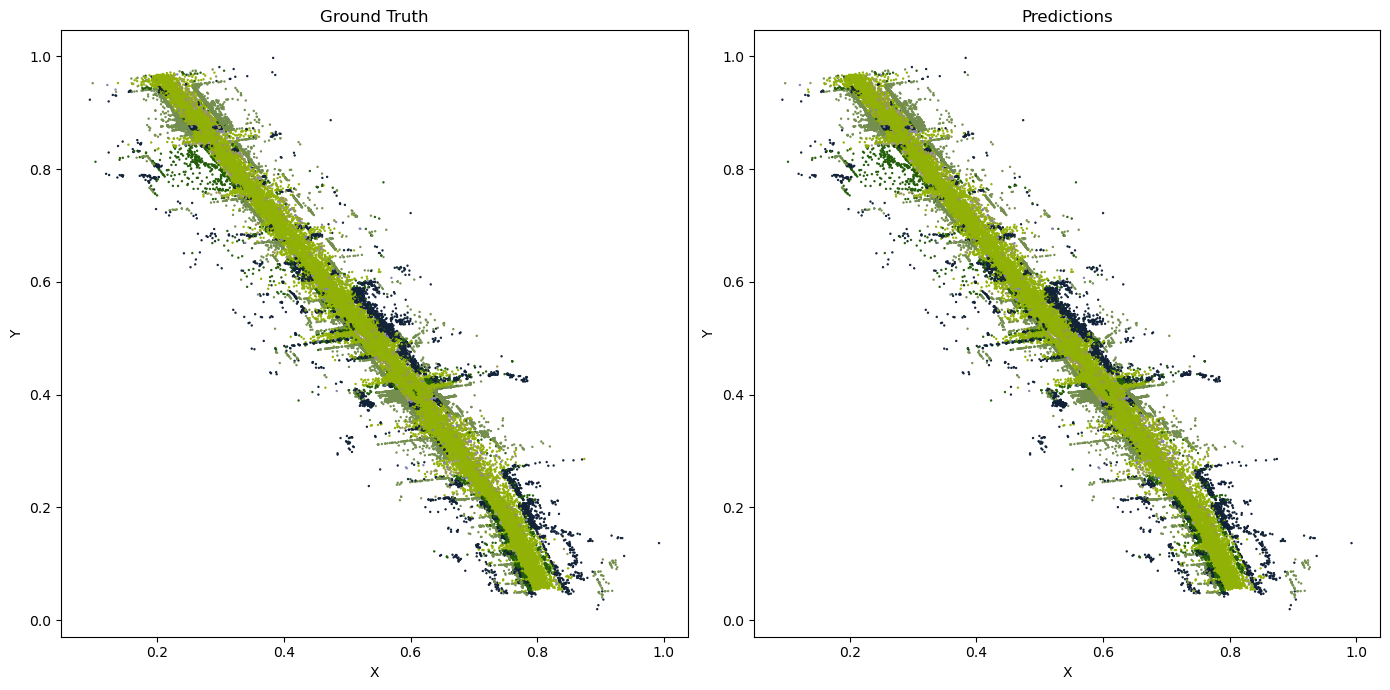

In [118]:
# Visualize the subsampled data
plt.figure(figsize=(14, 7))

# Scatter plot ground truth
plt.subplot(1, 2, 1)
plt.scatter(X_test_subsample[:, 0], X_test_subsample[:, 1], c=test_colors, s=0.5)
plt.title("Ground Truth")
plt.xlabel("X")
plt.ylabel("Y")

# Scatter plot predictions
plt.subplot(1, 2, 2)
plt.scatter(X_test_subsample[:, 0], X_test_subsample[:, 1], c=pred_colors, s=0.5)
plt.title("Predictions")
plt.xlabel("X")
plt.ylabel("Y")

plt.tight_layout()

In [119]:
dataset_parma=f"{data_folder}LAS/21/17/Run 172099_20231206_131419_0017_SPATIAL_SUBSAMPLED_2023-12-24_20h52_49_791.las"

In [120]:
las_data = laspy.read(dataset_parma)
points_parma = np.vstack((las_data.x, las_data.y, las_data.z)).transpose()
colors_parma = np.vstack((las_data.red, las_data.green, las_data.blue)).transpose() / 65535.0 # it is a 16 bit value and that is the maximum

positional_offset_parma = points_parma.mean(axis=0)
points_parma -= positional_offset_parma

features_parma = np.concatenate([points_parma, colors_parma], axis = 1)
features_scaled_parma = scaler.transform(features_parma)

In [121]:
# Make predictions
y_pred_parma = rf_classifier.predict(features_scaled_parma)

In [122]:
# Extract x, y, z from features
xyz = features_parma[:, :3]

# Define a fixed color map for 7 classes
fixed_colors = {
    0: [1.0, 0.0, 0.0],  # Red
    1: [0.0, 1.0, 0.0],  # Green
    2: [0.0, 0.0, 1.0],  # Blue
    3: [1.0, 1.0, 0.0],  # Yellow
    4: [1.0, 0.0, 1.0],  # Magenta
    5: [0.0, 1.0, 1.0],  # Cyan
    6: [0.5, 0.5, 0.5],  # Gray
}

# Map predictions to colors
predicted_colors = np.array([fixed_colors[label] for label in y_pred_parma])

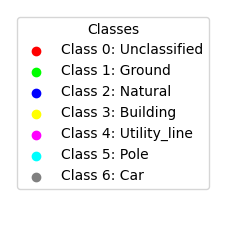

In [123]:
# Create a Matplotlib legend
plt.figure(figsize=(3, 3))
classes = ['Unclassified', 'Ground', 'Natural', 
           'Building', 'Utility_line', 'Pole', 'Car']
for cls, color in fixed_colors.items():
    plt.scatter([], [], color=color, label=f"Class {cls}: {classes[cls]}")
plt.legend(loc="upper left", title="Classes")
plt.axis("off")
plt.show()

In [124]:
# Create Open3D PointCloud
point_cloud = o3d.geometry.PointCloud()

# Assign points (x, y, z)
point_cloud.points = o3d.utility.Vector3dVector(xyz)

# Assign colors
point_cloud.colors = o3d.utility.Vector3dVector(predicted_colors)

In [125]:
# Visualize
o3d.visualization.draw_geometries([point_cloud])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


In [104]:
# Add classification directly to las_data
las_data.classification = y_pred_parma.astype(np.uint8)

# Optionally, save the updated LAS file
output_file = data_folder + "updated_point_cloud.las"
las_data.write(output_file)